In [1]:
# Imports y configuración
import os, sys, json, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Rutas (consistentes con otros notebooks)
PROJ_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
DATA_PATH = os.path.join(PROJ_ROOT, "data", "processed", "mortalidad")
BASE_OUT = os.path.join(PROJ_ROOT, "modelos", "outputs")
NOTEBOOK_NAME = os.path.splitext(os.path.basename(os.environ.get("NOTEBOOK_BASENAME", "b_09_ml.ipynb")))[0]
OUT_DIR = os.path.join(BASE_OUT, "output", NOTEBOOK_NAME)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"Usando datos desde: {DATA_PATH}")
print(f"Guardando resultados en: {OUT_DIR}")

pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 50)
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (10,5)

Usando datos desde: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/data/processed/mortalidad
Guardando resultados en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_09_ml


In [2]:
# Estilo (viz.style) y paleta corporativa
for candidate in ("src", "../src", "../../src", "../../../src"):
    p = os.path.abspath(candidate)
    if os.path.isdir(p) and p not in sys.path:
        sys.path.append(p)
try:
    import importlib, viz.style as _vstyle
    importlib.reload(_vstyle)
except Exception:
    pass
from viz.style import apply_matplotlib_style, get_palette, get_sequential_cmap

apply_matplotlib_style(
    n_colors=7,
    base_font_size=11,
    seaborn_style="white",
    background="white",
    transparent=False,
)
pal = get_palette(5)
color_obs, color_pred, color_vline = pal[0], pal[1], pal[4]
print("Estilo aplicado.")

Estilo aplicado.


In [3]:
# Carga de datos y construcción matriz edad×año
file_long = os.path.join(DATA_PATH, "tasas_mortalidad_gret_per.csv")
df_long = pd.read_csv(file_long)
df_long = df_long.rename(columns={"ano": "year", "gr_et": "age"})

EPS = 1e-12
df_long_m = df_long[["year", "age", "tasa_x100k"]].copy()
df_long_m['m'] = (df_long_m['tasa_x100k'] / 1e5).clip(lower=EPS)

# Matrices en escala m y log(m)
mat = df_long_m.pivot(index='age', columns='year', values='m').sort_index()
ages = mat.index.values
all_periods = np.array(sorted(mat.columns.values))
mat = mat.reindex(columns=all_periods)
mat_log = np.log(mat.clip(lower=EPS))
print(mat.shape, mat.index.min(), mat.index.max(), all_periods.min(), all_periods.max())
mat.head()

(17, 45) 1 17 1979 2023


year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000049,0.000042,0.000044,0.000039,0.000028,0.000022,0.000024,0.000018,0.000015,0.000014,0.000011,0.000010,0.000009,0.000009,0.000008,0.000006,0.000006,0.000005,0.000004,0.000006,0.000006,0.000006,0.000005,8.499482e-06,0.000007,6.534167e-06,0.000006,7.710106e-06,0.000005,8.390200e-06,0.000006,0.000003,3.653421e-06,3.153650e-06,5.815563e-06,2.921598e-06,2.398540e-06,2.666065e-06,2.392366e-06,3.153282e-06,3.668709e-06,0.000002,3.129253e-06,4.469724e-06,0.000003
2,0.000012,0.000011,0.000013,0.000010,0.000006,0.000009,0.000009,0.000007,0.000007,0.000005,0.000003,0.000004,0.000004,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000001,0.000002,0.000003,2.798329e-06,0.000002,7.009429e-07,0.000003,1.657103e-06,0.000002,1.449898e-06,0.000002,0.000002,1.249956e-06,2.527166e-07,5.106775e-07,7.732517e-07,1.559143e-06,5.224731e-07,2.617115e-07,4.921904e-07,7.389123e-07,0.000001,4.932269e-07,2.482730e-07,0.000002
3,0.000009,0.000006,0.000010,0.000009,0.000006,0.000007,0.000004,0.000005,0.000003,0.000005,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,7.387396e-07,0.000003,9.613654e-07,0.000002,9.458863e-07,0.000002,9.408289e-07,0.000002,0.000002,7.141590e-07,4.802836e-07,4.853084e-07,9.816835e-07,7.445327e-07,1.002307e-06,1.515173e-06,1.401163e-06,1.396822e-06,0.000001,9.338040e-07,1.178135e-06,0.000001
4,0.000015,0.000013,0.000017,0.000014,0.000012,0.000014,0.000015,0.000008,0.000011,0.000011,0.000008,0.000006,0.000008,0.000008,0.000007,0.000007,0.000006,0.000009,0.000005,0.000006,0.000006,0.000006,0.000006,7.621104e-06,0.000005,3.371316e-06,0.000003,4.305802e-06,0.000005,4.929344e-06,0.000003,0.000003,3.584486e-06,2.853929e-06,3.324185e-06,2.852953e-06,2.863328e-06,4.075270e-06,2.891899e-06,3.997186e-06,3.474033e-06,0.000004,4.770033e-06,5.670935e-06,0.000005
5,0.000034,0.000038,0.000032,0.000031,0.000027,0.000026,0.000019,0.000019,0.000023,0.000018,0.000015,0.000014,0.000014,0.000014,0.000013,0.000016,0.000013,0.000012,0.000011,0.000012,0.000012,0.000011,0.000012,1.439396e-05,0.000011,1.262662e-05,0.000008,8.655184e-06,0.000009,1.042390e-05,0.000010,0.000005,7.747502e-06,6.875696e-06,5.778954e-06,8.438986e-06,5.401696e-06,6.803984e-06,5.055585e-06,7.018536e-06,7.070214e-06,0.000007,1.016314e-05,1.279901e-05,0.000011


In [4]:
# Dataset largo (para agregados/exports) como en otros notebooks
df_ml = (mat.reset_index()
           .melt(id_vars='age', var_name='year', value_name='m')
           .dropna())
df_ml['year'] = df_ml['year'].astype(int)
df_ml['age'] = df_ml['age'].astype(int)
df_ml['cohort'] = df_ml['year'] - df_ml['age']
df_ml['log_m'] = np.log(df_ml['m'].clip(lower=1e-12))
train_mask_year = (df_ml['year'] >= 1979) & (df_ml['year'] <= 2018)
val_mask_year = (df_ml['year'] >= 2019) & (df_ml['year'] <= 2023)
train_df = df_ml.loc[train_mask_year].copy()
val_df = df_ml.loc[val_mask_year].copy()
print(f"Filas train: {len(train_df)} | Filas val: {len(val_df)}")

Filas train: 680 | Filas val: 85


In [5]:
# Utilidades para construir secuencias (LSTM) desde mat_log
def build_sequences_from_matlog(mat_log_df, ages_arr, periods_arr, lookback):
    # Entrada: mat_log_df: DataFrame (age x year) con log(m)
    # Salida: X (N, lookback, 1), y (N,), ages_idx (N,), years (N,)
    mat_vals = mat_log_df.values.astype(float)
    n_age, n_t = mat_vals.shape
    X_list, y_list, age_list, year_list = [], [], [], []
    for ia in range(n_age):
        series = mat_vals[ia, :]
        for t in range(lookback, n_t):
            y = series[t]
            x_seq = series[t-lookback:t]
            X_list.append(x_seq.reshape(-1, 1))
            y_list.append(y)
            age_list.append(ages_arr[ia])
            year_list.append(int(periods_arr[t]))
    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
    ages_seq = np.array(age_list)
    years_seq = np.array(year_list)
    return X, y, ages_seq, years_seq

def standardize_with_train(mu, sigma, arr):
    return (arr - mu) / (sigma + 1e-12)

def inverse_standardize(mu, sigma, arr):
    return arr * (sigma + 1e-12) + mu

In [6]:
# Importar/instalar TensorFlow (Keras)
import importlib
try:
    import tensorflow as tf
except ImportError:
    import sys, subprocess
    print("Instalando paquete 'tensorflow'...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tensorflow'])
    import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.17.0


In [9]:
# Preparación de datasets (con estandarización basada en train)
def prepare_datasets(lookback):
    X_all, y_all, ages_seq, years_seq = build_sequences_from_matlog(mat_log, ages, all_periods, lookback)
    # Split por año de destino
    train_mask = (years_seq >= 1979) & (years_seq <= 2018)
    val_mask = (years_seq >= 2019) & (years_seq <= 2023)
    X_train_raw, y_train_raw = X_all[train_mask], y_all[train_mask]
    X_val_raw, y_val_raw = X_all[val_mask], y_all[val_mask]
    ages_train, years_train = ages_seq[train_mask], years_seq[train_mask]
    ages_val, years_val = ages_seq[val_mask], years_seq[val_mask]
    # Estandarización por media/desv de y(train)
    mu, sigma = float(y_train_raw.mean()), float(y_train_raw.std() + 1e-12)
    y_train = standardize_with_train(mu, sigma, y_train_raw)
    y_val = standardize_with_train(mu, sigma, y_val_raw)
    X_train = standardize_with_train(mu, sigma, X_train_raw)
    X_val = standardize_with_train(mu, sigma, X_val_raw)
    return (X_train, y_train, ages_train, years_train,
            X_val, y_val, ages_val, years_val,
            mu, sigma)

from tensorflow import keras
from tensorflow.keras import layers

def build_lstm_model(lookback, units=64, dropout=0.0, lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(lookback, 1)),
        layers.LSTM(units, activation='tanh'),
        layers.Dropout(dropout),  # con 0.0 no aplica dropout
        layers.Dense(1)
    ])
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')
    return model

# Optimización sencilla de hiperparámetros
Búsqueda aleatoria sobre pocas combinaciones: lookback, unidades LSTM, dropout, learning rate y batch size. Criterio: RMSE en validación (escala original m).

In [10]:
import itertools, random
random.seed(42); np.random.seed(42); tf.random.set_seed(42)

param_grid = {
    'lookback': [3, 5, 7],
    'units': [32, 64],
    'dropout': [0.0, 0.2],
    'lr': [1e-3, 5e-3],
    'batch_size': [64, 128]
}
all_combos = list(itertools.product(param_grid['lookback'], param_grid['units'], param_grid['dropout'], param_grid['lr'], param_grid['batch_size']))
random.shuffle(all_combos)
sampled = all_combos[:min(12, len(all_combos))]  # limitar evaluaciones

best_rmse_val = float('inf')
best_result = None
best_model = None

for (lk, units, dropout, lr, batch_size) in sampled:
    print(f"Probando: lookback={lk}, units={units}, dropout={dropout}, lr={lr}, batch={batch_size}")
    X_train, y_train, ages_train, years_train, X_val, y_val, ages_val, years_val, mu, sigma = prepare_datasets(lk)
    model = build_lstm_model(lk, units=units, dropout=dropout, lr=lr)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    hist = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      epochs=120,
                      batch_size=batch_size,
                      verbose=0,
                      callbacks=[es])
    # Predicción y métricas en validación (escala m)
    y_val_pred_z = model.predict(X_val, verbose=0).reshape(-1)
    y_val_pred_log = inverse_standardize(mu, sigma, y_val_pred_z)
    y_val_log = inverse_standardize(mu, sigma, y_val)
    m_val_pred = np.exp(y_val_pred_log)
    m_val_obs = np.exp(y_val_log)
    rmse_val = float(np.sqrt(np.mean((m_val_pred - m_val_obs)**2)))
    print(f"  RMSE_val={rmse_val:.4e}")
    if rmse_val < best_rmse_val:
        best_rmse_val = rmse_val
        best_result = {
            'lookback': lk, 'units': units, 'dropout': dropout, 'lr': lr, 'batch_size': batch_size,
            'mu': mu, 'sigma': sigma
        }
        best_model = model
        # Guardar también los datasets asociados al mejor
        best_cache = {
            'X_train': X_train, 'y_train': y_train, 'ages_train': ages_train, 'years_train': years_train,
            'X_val': X_val, 'y_val': y_val, 'ages_val': ages_val, 'years_val': years_val
        }
print("Mejor configuración:", best_result)
print(f"Mejor RMSE_val: {best_rmse_val:.4e}")

Probando: lookback=5, units=64, dropout=0.2, lr=0.001, batch=128
  RMSE_val=1.6365e-05
Probando: lookback=5, units=32, dropout=0.2, lr=0.005, batch=128
  RMSE_val=1.6365e-05
Probando: lookback=5, units=32, dropout=0.2, lr=0.005, batch=128
  RMSE_val=1.4694e-05
Probando: lookback=5, units=64, dropout=0.0, lr=0.001, batch=64
  RMSE_val=1.4694e-05
Probando: lookback=5, units=64, dropout=0.0, lr=0.001, batch=64
  RMSE_val=2.5274e-05
Probando: lookback=3, units=64, dropout=0.0, lr=0.005, batch=64
  RMSE_val=2.5274e-05
Probando: lookback=3, units=64, dropout=0.0, lr=0.005, batch=64
  RMSE_val=1.5877e-05
Probando: lookback=5, units=32, dropout=0.2, lr=0.001, batch=128
  RMSE_val=1.5877e-05
Probando: lookback=5, units=32, dropout=0.2, lr=0.001, batch=128
  RMSE_val=1.4559e-05
Probando: lookback=3, units=64, dropout=0.0, lr=0.001, batch=128
  RMSE_val=1.4559e-05
Probando: lookback=3, units=64, dropout=0.0, lr=0.001, batch=128
  RMSE_val=2.3610e-05
Probando: lookback=5, units=64, dropout=0.2, lr

In [11]:
# Predicciones finales con el mejor modelo (train/val) y métricas
lk = best_result['lookback']; mu = best_result['mu']; sigma = best_result['sigma']
X_train = best_cache['X_train']; y_train = best_cache['y_train']
X_val = best_cache['X_val']; y_val = best_cache['y_val']
ages_train = best_cache['ages_train']; years_train = best_cache['years_train']
ages_val = best_cache['ages_val']; years_val = best_cache['years_val']

# Predicción
yhat_train_z = best_model.predict(X_train, verbose=0).reshape(-1)
yhat_val_z = best_model.predict(X_val, verbose=0).reshape(-1)
yhat_train_log = inverse_standardize(mu, sigma, yhat_train_z)
yhat_val_log = inverse_standardize(mu, sigma, yhat_val_z)
y_train_log = inverse_standardize(mu, sigma, y_train)
y_val_log = inverse_standardize(mu, sigma, y_val)

m_train_pred = np.exp(yhat_train_log); m_val_pred = np.exp(yhat_val_log)
m_train_obs = np.exp(y_train_log);  m_val_obs = np.exp(y_val_log)

def smape(y_true, y_pred, eps=1e-12):
    return 100 * np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))
def wape(y_true, y_pred, eps=1e-12):
    return 100 * (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps))

RMSE_train = float(np.sqrt(np.mean((m_train_pred - m_train_obs)**2)))
MAE_train = float(np.mean(np.abs(m_train_pred - m_train_obs)))
sMAPE_train = float(smape(m_train_obs, m_train_pred))
MAPE_train = float(np.mean(np.abs((m_train_obs - m_train_pred) / (m_train_obs + 1e-12))) * 100)
WAPE_train = float(wape(m_train_obs, m_train_pred))
RMSE_val = float(np.sqrt(np.mean((m_val_pred - m_val_obs)**2)))
MAE_val = float(np.mean(np.abs(m_val_pred - m_val_obs)))
sMAPE_val = float(smape(m_val_obs, m_val_pred))
MAPE_val = float(np.mean(np.abs((m_val_obs - m_val_pred) / (m_val_obs + 1e-12))) * 100)
WAPE_val = float(wape(m_val_obs, m_val_pred))

print("Métricas (escala original por persona):")
print(f"- Train | RMSE: {RMSE_train:.4e} | MAE: {MAE_train:.4e} | MAPE: {MAPE_train:.2f}% | sMAPE: {sMAPE_train:.2f}% | WAPE: {WAPE_train:.2f}%")
print(f"- Val   | RMSE: {RMSE_val:.4e} | MAE: {MAE_val:.4e} | MAPE: {MAPE_val:.2f}% | sMAPE: {sMAPE_val:.2f}% | WAPE: {WAPE_val:.2f}%")

Métricas (escala original por persona):
- Train | RMSE: 1.5409e-05 | MAE: 8.3885e-06 | MAPE: 18.07% | sMAPE: 16.40% | WAPE: 11.11%
- Val   | RMSE: 1.4105e-05 | MAE: 7.7033e-06 | MAPE: 23.66% | sMAPE: 26.08% | WAPE: 18.10%


In [12]:
# Reconstrucción de matrices predichas y agregados por período
def build_matrix_from_pred_list(ages_vec, years_vec, pred_m, ages_index, periods_index):
    dfp = pd.DataFrame({'age': ages_vec, 'year': years_vec, 'm_pred': pred_m})
    mat_pred = dfp.pivot(index='age', columns='year', values='m_pred').reindex(index=ages_index, columns=periods_index)
    return mat_pred

mat_train_pred = build_matrix_from_pred_list(ages_train, years_train, m_train_pred, ages, all_periods)
mat_val_pred = build_matrix_from_pred_list(ages_val, years_val, m_val_pred, ages, all_periods)

# Matrices en escala x100k
mat_obs_100k = mat * 1e5
mat_train_pred_100k = mat_train_pred * 1e5
mat_val_pred_100k = mat_val_pred * 1e5

# Agregados promedio por período (usando df_ml)
df_period_train = train_df.groupby('year')[['m']].mean().reset_index().rename(columns={'year':'period','m':'obs'})
df_period_val = val_df.groupby('year')[['m']].mean().reset_index().rename(columns={'year':'period','m':'obs'})
# Añadir predicciones promedio por período donde existan
train_pred_df = pd.DataFrame({'year': years_train, 'm_pred': m_train_pred}).groupby('year')[['m_pred']].mean().reset_index()
val_pred_df = pd.DataFrame({'year': years_val, 'm_pred': m_val_pred}).groupby('year')[['m_pred']].mean().reset_index()
df_period_train = df_period_train.merge(train_pred_df.rename(columns={'year':'period'}), how='left', on='period')
df_period_val = df_period_val.merge(val_pred_df.rename(columns={'year':'period'}), how='left', on='period')
print('Matrices y agregados listos.')

Matrices y agregados listos.


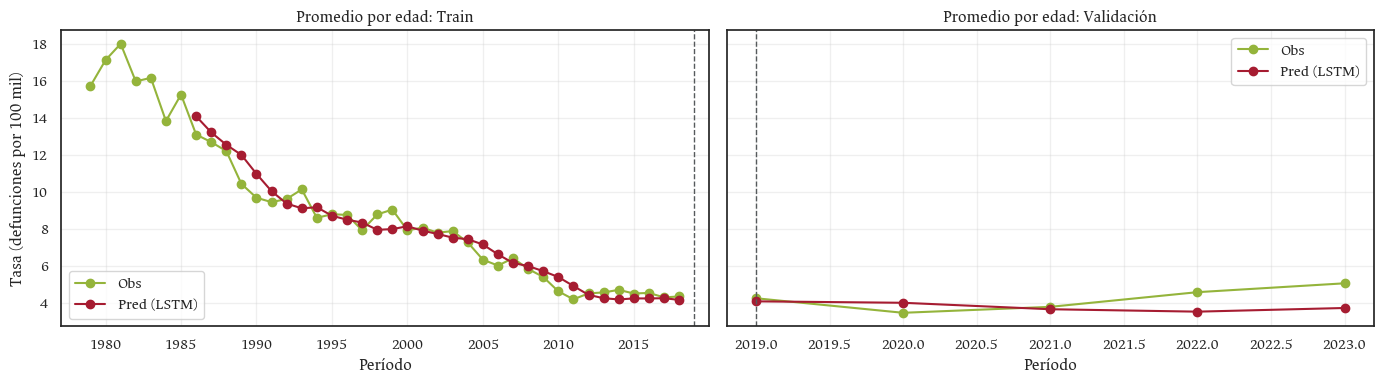

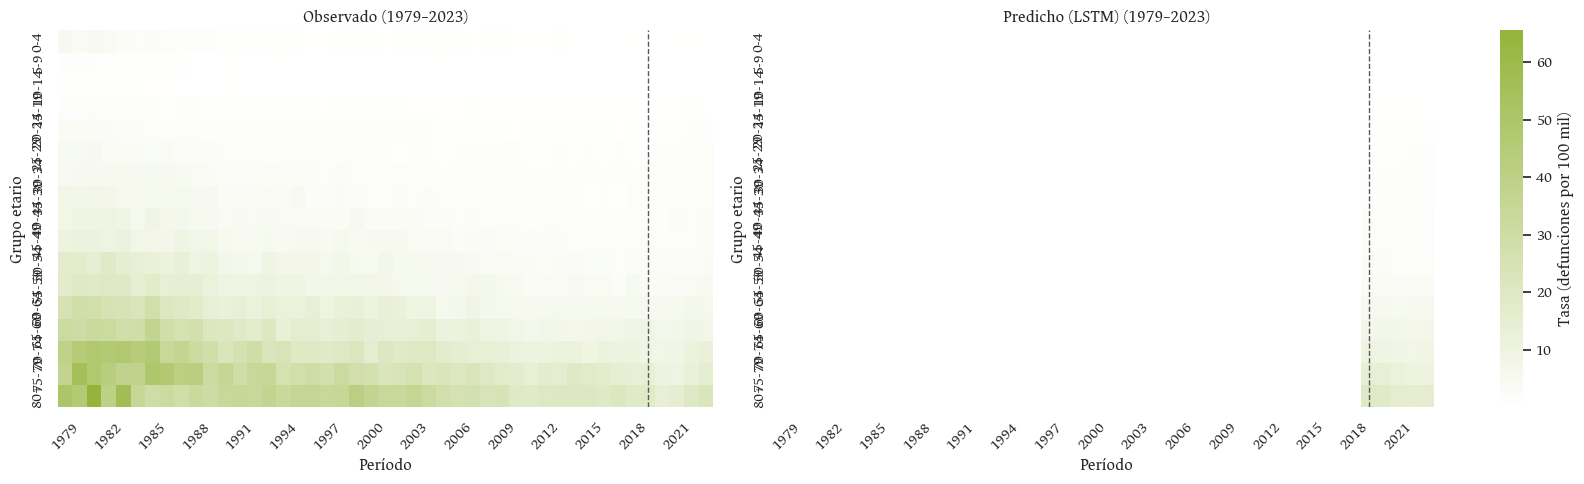

In [13]:
# Gráficos principales: líneas y heatmaps (paleta corporativa)
tick_years = np.arange(1979, 2022, 3)
ages_sorted = np.sort(ages)
if ages_sorted.min() == 0:
    age_labels = [f"{a*5}-{a*5+4}" if a < 16 else "80+" for a in ages_sorted]
else:
    age_labels = [f"{(a-1)*5}-{(a-1)*5+4}" if a < 17 else "80+" for a in ages_sorted]

# Líneas promedio por período (100k)
fig, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
ax[0].plot(df_period_train['period'], df_period_train['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[0].plot(df_period_train['period'], df_period_train['m_pred']*1e5, label='Pred (LSTM)', marker='o', color=color_pred)
ax[0].set_title('Promedio por edad: Train'); ax[0].set_xlabel('Período'); ax[0].set_ylabel('Tasa (defunciones por 100 mil)'); ax[0].grid(alpha=0.3); ax[0].legend(); ax[0].axvline(2019, color=color_vline, ls='--', lw=1)
ax[1].plot(df_period_val['period'], df_period_val['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[1].plot(df_period_val['period'], df_period_val['m_pred']*1e5, label='Pred (LSTM)', marker='o', color=color_pred)
ax[1].set_title('Promedio por edad: Validación'); ax[1].set_xlabel('Período'); ax[1].grid(alpha=0.3); ax[1].legend(); ax[1].axvline(2019, color=color_vline, ls='--', lw=1)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'lineas_obs_vs_pred_lstm_100k.png'), dpi=180); plt.show()

# Heatmaps Observado vs Predicho
# Construir matriz pred completa con train y val
mat_pred_full_100k = pd.DataFrame(np.nan, index=ages, columns=all_periods, dtype=float)
if mat_train_pred_100k is not None:
    mat_pred_full_100k.loc[:, mat_train_pred_100k.columns] = mat_train_pred_100k.values
if mat_val_pred_100k is not None:
    mat_pred_full_100k.loc[:, mat_val_pred_100k.columns] = mat_val_pred_100k.values

vmin = float(np.nanmin([mat_obs_100k.values.min(), np.nanmin(mat_pred_full_100k.values)]))
vmax = float(np.nanmax([mat_obs_100k.values.max(), np.nanmax(mat_pred_full_100k.values)]))
cmap_seq = get_sequential_cmap(index=0)

fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1,3, width_ratios=[1,1,0.035])
ax0 = fig.add_subplot(gs[0,0]); ax1 = fig.add_subplot(gs[0,1], sharey=ax0); cax = fig.add_subplot(gs[0,2])

sns.heatmap(mat_obs_100k, ax=ax0, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=False)
ax0.set_title('Observado (1979–2023)'); ax0.set_xlabel('Período'); ax0.set_ylabel('Grupo etario')

sns.heatmap(mat_pred_full_100k, ax=ax1, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cax)
ax1.set_title('Predicho (LSTM) (1979–2023)'); ax1.set_xlabel('Período'); ax1.set_ylabel('Grupo etario')

ax0.set_yticks(np.arange(len(age_labels))+0.5); ax0.set_yticklabels(age_labels)
ax1.set_yticks(np.arange(len(age_labels))+0.5); ax1.set_yticklabels(age_labels)
period_list = list(all_periods)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax0, ax1):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)
idx_2019 = np.where(all_periods == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    ax0.axvline(xline, color=color_vline, ls='--', lw=1)
    ax1.axvline(xline, color=color_vline, ls='--', lw=1)
cax.set_ylabel('Tasa (defunciones por 100 mil)')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'matrices_obs_pred_lstm_1979_2023_100k.png'), dpi=180); plt.show()

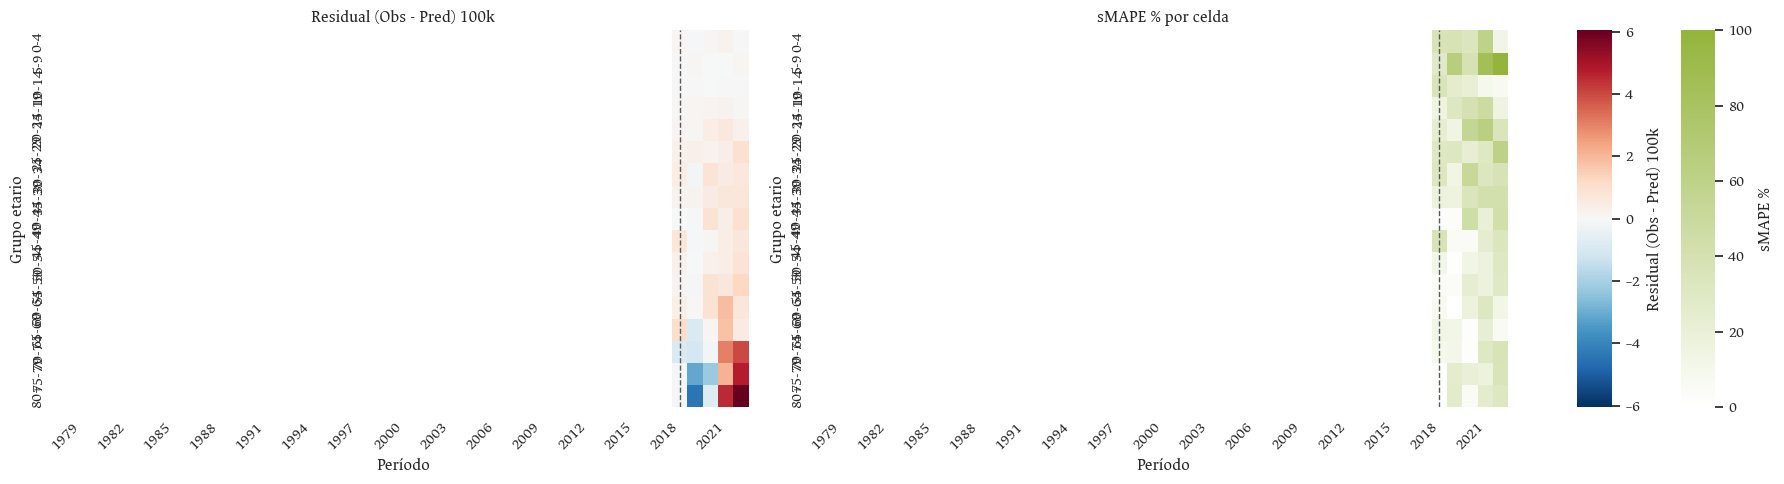

Generados heatmaps de residuales y sMAPE para LSTM.


In [14]:
# Heatmaps residuales y sMAPE por celda (100k)
EPS_CELL = 1e-12
resid_100k = mat_obs_100k.values - mat_pred_full_100k.values
smape_cell = (2 * np.abs(mat_pred_full_100k.values - mat_obs_100k.values) / (np.abs(mat_pred_full_100k.values) + np.abs(mat_obs_100k.values) + EPS_CELL))*100
vmax_res = np.nanmax(np.abs(resid_100k)); vmin_res = -vmax_res
vmin_sm, vmax_sm = 0, min(100, np.nanmax(smape_cell))

cmap_seq = get_sequential_cmap(index=0)
fig = plt.figure(figsize=(18,5))
gs = fig.add_gridspec(1,4, width_ratios=[1,1,0.05,0.05])
ax_r = fig.add_subplot(gs[0,0]); ax_s = fig.add_subplot(gs[0,1], sharey=ax_r); cax_r = fig.add_subplot(gs[0,2]); cax_s = fig.add_subplot(gs[0,3])

sns.heatmap(resid_100k, ax=ax_r, cmap='RdBu_r', vmin=vmin_res, vmax=vmax_res, cbar=True, cbar_ax=cax_r)
ax_r.set_title('Residual (Obs - Pred) 100k'); ax_r.set_xlabel('Período'); ax_r.set_ylabel('Grupo etario')

sns.heatmap(smape_cell, ax=ax_s, cmap=cmap_seq, vmin=vmin_sm, vmax=vmax_sm, cbar=True, cbar_ax=cax_s)
ax_s.set_title('sMAPE % por celda'); ax_s.set_xlabel('Período'); ax_s.set_ylabel('Grupo etario')

ax_r.set_yticks(np.arange(len(age_labels))+0.5); ax_r.set_yticklabels(age_labels)
ax_s.set_yticks(np.arange(len(age_labels))+0.5); ax_s.set_yticklabels(age_labels)
period_list = list(all_periods)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax_r, ax_s):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)
idx_2019 = np.where(all_periods == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    for a in (ax_r, ax_s):
        a.axvline(xline, color=color_vline, ls='--', lw=1)
cax_r.set_ylabel('Residual (Obs - Pred) 100k')
cax_s.set_ylabel('sMAPE %')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'heatmaps_residual_smape_lstm_100k.png'), dpi=180); plt.show()
print('Generados heatmaps de residuales y sMAPE para LSTM.')

In [15]:
# Exportar matrices y formato long de predicciones (100k)
# Matriz completa en m (puede contener NaN en periodos sin predicción por lookback)
mat_pred_full_m = mat_pred_full_100k / 1e5
mat_pred_full_m.index.name = 'gr_et'
mat_pred_full_100k.index.name = 'gr_et'
mat_pred_full_m.reset_index().to_csv(os.path.join(OUT_DIR,'lstm_matriz_pred_m.csv'), index=False)
mat_pred_full_100k.reset_index().to_csv(os.path.join(OUT_DIR,'lstm_matriz_pred_tasa_x100k.csv'), index=False)

# Exportar formato long con obs/pred y errores (100k) solo donde hay pred
pred_train_long = pd.DataFrame({'dataset':'train','year': years_train, 'age': ages_train, 'pred_tasa_x100k': m_train_pred * 1e5})
pred_val_long = pd.DataFrame({'dataset':'valid','year': years_val, 'age': ages_val, 'pred_tasa_x100k': m_val_pred * 1e5})
pred_long = pd.concat([pred_train_long, pred_val_long], ignore_index=True)
# Añadir obs y cohort
aux = df_ml[['year','age','m','cohort']].copy(); aux['obs_tasa_x100k'] = aux['m'] * 1e5
pred_long = pred_long.merge(aux, on=['year','age'], how='left')
pred_long['abs_error_100k'] = (pred_long['pred_tasa_x100k'] - pred_long['obs_tasa_x100k']).abs()
pred_long['rel_abs_error'] = pred_long['abs_error_100k'] / (pred_long['obs_tasa_x100k'].abs() + 1e-12)
pred_long = pred_long[['dataset','year','age','cohort','obs_tasa_x100k','pred_tasa_x100k','abs_error_100k','rel_abs_error']].sort_values(['dataset','year','age']).reset_index(drop=True)
pred_long.to_csv(os.path.join(OUT_DIR,'lstm_predicciones_long_100k.csv'), index=False)
print('Exportos LSTM: matrices y formato long.')

Exportos LSTM: matrices y formato long.
